In [22]:
# Importing modules
%matplotlib inline

import os, string
import random
import pandas as pd
import numpy as np
from scipy import stats, spatial
from matplotlib import pylab as plt
from IPython.display import display
from PIL import Image, ImageDraw, ImageFont, ImageFilter
from skimage.morphology import convex_hull_image
### Own functions
import myner as my

In [23]:
import seaborn as sns
sns.set_context("paper", font_scale=1.25)
sns.set_style("ticks")

In [24]:
# Reading and cleaning data
raw = my.collect_data('/home/akkus/Documents/NumLab/data/Parity_font', delim=' ')
data = my.clean_data(raw, 'B', 'num_comp', header={'A':'ID', 'B':'Task', 'C':'Font', 'D':'First_code', 'E':'Resp_code', 'F':'Value', 'G':'Resp_key', 'H':'RT'})

In [25]:
# Excluding a certain value (optional)
excluded = 0
data = data[data['Value'] != excluded]
values = sorted(set(data['Value']))

# Converting values to string 
values_str = "".join(str(x) for x in values)

In [26]:
def compute_pellis_pc(font_pil, letter):
    img = Image.new('1', (100, 100), 'white')
    draw = ImageDraw.Draw(img)
    draw.text((0,0), letter, font=font_pil, fill='black')
    ink = len([x for x in list(img.getdata()) if x == 0])
    def draw_contour(x=0, y=0, tint='black'):
        draw.text((x+1,y), letter, font=font_pil, fill=tint)
        draw.text((x+1,y+1), letter, font=font_pil, fill=tint)
        draw.text((x,y+1), letter, font=font_pil, fill=tint)
        draw.text((x-1,y), letter, font=font_pil, fill=tint)
        draw.text((x-1,y-1), letter, font=font_pil, fill=tint)
        draw.text((x,y-1), letter, font=font_pil, fill=tint)
        draw.text((x,y), letter, font=font_pil, fill='white')
    draw_contour(1,0)
    draw_contour(-1,0)
    draw_contour(0,1)
    draw_contour(0,-1)
    draw_contour(0,0)
    display(img)
    perimeter = len([x for x in list(img.getdata()) if x == 0])/3
    complexity = np.square(perimeter)/ink/np.pi
    print 'Ink area: ', ink
    print 'Perimeter: ', perimeter
    print 'Complexity: ', complexity
    return ink, perimeter, complexity

FreeSans.ttf


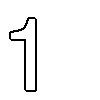

Ink area:  741
Perimeter:  125
Complexity:  6.68450760986


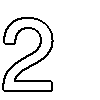

Ink area:  1390
Perimeter:  240
Complexity:  13.0507053335


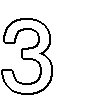

Ink area:  1393
Perimeter:  232
Complexity:  12.095775675


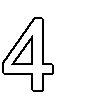

Ink area:  1243
Perimeter:  203
Complexity:  10.5042262441


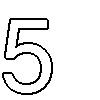

Ink area:  1401
Perimeter:  238
Complexity:  12.7323954474


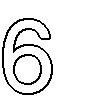

Ink area:  1562
Perimeter:  246
Complexity:  12.095775675


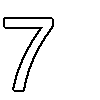

Ink area:  891
Perimeter:  177
Complexity:  11.1408460164


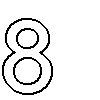

Ink area:  1623
Perimeter:  243
Complexity:  11.4591559026


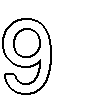

Ink area:  1529
Perimeter:  242
Complexity:  12.095775675
Courier_New.ttf


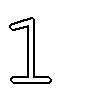

Ink area:  459
Perimeter:  157
Complexity:  16.8704239677


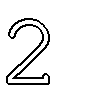

Ink area:  577
Perimeter:  209
Complexity:  23.8732414638


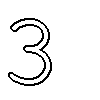

Ink area:  557
Perimeter:  188
Complexity:  20.0535228296


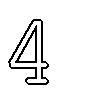

Ink area:  622
Perimeter:  206
Complexity:  21.6450722605


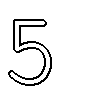

Ink area:  583
Perimeter:  200
Complexity:  21.6450722605


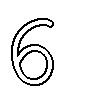

Ink area:  681
Perimeter:  222
Complexity:  22.9183118052


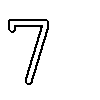

Ink area:  409
Perimeter:  150
Complexity:  17.5070437401


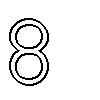

Ink area:  695
Perimeter:  229
Complexity:  23.8732414638


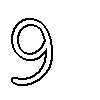

Ink area:  658
Perimeter:  220
Complexity:  23.2366216914


,FreeSans.ttf,Courier_New.ttf,Diff
1,125,157,-32
2,240,209,31
3,232,188,44
4,203,206,-3
5,238,200,38
6,246,222,24
7,177,150,27
8,243,229,14
9,242,220,22


In [27]:
numbers = values_str
font_names = ['FreeSans.ttf', 'Courier_New.ttf']

complexity = pd.DataFrame(index=list(numbers))
for font in font_names:
    print font
    pc_list = []
    font_pil = ImageFont.truetype(font, 100)
    for letter in numbers:
        pc_list.append(compute_pellis_pc(font_pil, letter)[1])
    complexity[font] = pc_list
complexity['Diff'] = complexity[font_names[0]] - complexity[font_names[1]]
    
display(complexity)    

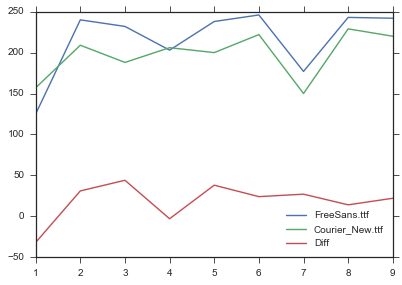

In [28]:
complexity.plot()

In [29]:
# New variables

### RT in ms
data = data.assign(RTms = data['RT']*1000)

### Resp_side
def add_respside(data, key='Resp_key'):
    resp_side = []
    for i, key in enumerate(data[key]):
        if key == 'q':
            resp_side.insert(i, 'left')
        elif key == 'p':
            resp_side.insert(i, 'right')
        else:
            resp_side.insert(i, 'miss')
    data = data.assign(Resp_side = resp_side)
    return data

data = add_respside(data)

### Parity
parity = []
for i, no in enumerate(data['Value']):
    if no == 2 or no == 4 or no == 6 or no == 8:
        parity.insert(i, 2)
    else:
        parity.insert(i, 1)
        
data = data.assign(Parity = parity)

###Error
def add_error_parity(data):
    error = []        
    for i, arr in enumerate(data['Resp_code']):
        if arr == 'QP':
            if data.iloc[i]['Resp_side'] == 'left' and data.iloc[i]['Parity'] == 2:
                error.insert(i, 0)
            elif data.iloc[i]['Resp_side'] == 'right' and data.iloc[i]['Parity'] == 1:
                error.insert(i, 0)
            else:
                error.insert(i, 1)
        elif arr == 'PQ':
            if data.iloc[i]['Resp_side'] == 'left' and data.iloc[i]['Parity'] == 1:
                error.insert(i, 0)
            elif data.iloc[i]['Resp_side'] == 'right' and data.iloc[i]['Parity'] == 2:
                error.insert(i, 0)
            else:
                error.insert(i, 1)
    data = data.assign(Error = error)
    return data

data = add_error_parity(data)

### Block
block = []
for i, code in enumerate(data['Resp_code']):
    if data.iloc[i]['First_code'] == code:
        block.insert(i, 1)
    else:
        block.insert(i, 2)
        
data = data.assign(Block = block)

## Participants

In [30]:
# Participants
print sorted(set(data['ID']))
print 'N = %i'%len(set(data['ID']))

['1_1', '1_10', '1_2', '1_3', '1_4', '1_5', '1_6', '1_7', '1_8', '1_9', '2_1', '2_2', '2_3', '2_4', '2_5', '2_6', '2_7', '2_8', '2_9', '3_1', '3_2', '3_3', '3_4', '3_5', '4_1', '4_2', '4_3', '4_4', '4_5']
N = 29


In [31]:
# Count trials
trials = my.count_trial(data, sorted(set(data.ID)))
display(trials)

,L_t1,R_t1
1_1,180,180
1_10,180,180
1_2,180,180
1_3,180,180
1_4,180,180
1_5,180,180
1_6,180,180
1_7,180,180
1_8,180,180
1_9,180,180


In [32]:
# Removing participants with missing data
data = data[data['ID'] != '2_9']
data = data[data['ID'] != '1_7']

In [33]:
# Removing left handed participants
lefties = ['1_5', '1_10', '2_7', '2_9']
# for sub in lefties:
#     data = data[data['ID'] != sub]

In [34]:
# Error rates
errors = my.error_rates(data, sorted(set(data['ID'])))
display(errors)

,Mean error (%)
1_1,3.888889
1_10,6.944444
1_2,0.277778
1_3,5.000000
1_4,1.944444
1_5,5.555556
1_6,6.666667
1_8,0.000000
1_9,3.888889
2_1,2.222222


## Outliers based on error rate
Participants with an error rate greater than the mean + 2 standard deviation of the sample are excluded from the analysis.

In [35]:
# Filtering I.

### Error-rate outliers
def error_outlier(data, table, crit_er=0.10, std_range=None):
    if std_range != None:
        print 'Mean error: %.3f' %np.mean(table['Mean error (%)'])
        np.std(table['Mean error (%)'])
        crit_er = np.mean(table['Mean error (%)'])/100 + (std_range * np.std(table['Mean error (%)']))/100
    outlier_error = []
    for i, sub in enumerate(table.iterrows()):
        if table.iloc[i][0] >= crit_er*100:
            outlier_error.insert(i, sub[0])
    print 'Outliers (error rate above',crit_er*100,'%):'
    print outlier_error
    print 'N =', len(outlier_error)
    for i, sub in enumerate(outlier_error):
        data = data[data['ID'] != sub]
    return data

data = error_outlier(data, errors, std_range=2)

Mean error: 3.457
Outliers (error rate above 7.53740589655 %):
[]
N = 0


In [36]:
data = data[data['Resp_side'] == 'left']
# data = data[data['Block'] == 1]

In [37]:
# Filtering II.

### Erroneous responses
data = data[data['Error'] == 0]

# ## Extreme reaction times
# data = data[data['RTms'] <= 2000]
# data = data[data['RTms'] >= 200]

# # Extreme reaction times
# cleaned = []
# for sub in set(data['ID']):
#     sub_data = data[data['ID'] == sub]
#     for hand in set(sub_data['Resp_side']):
#         hand_data = sub_data[sub_data['Resp_side'] == hand]
#         for val in set(hand_data['Value']):
#             val_data = hand_data[hand_data['Value'] == val]
#             for font in set(val_data['Font']):
#                 cell = val_data[val_data['Font'] == font]
#                 while True:
#                     std = np.std(cell['RTms'])
#                     mean = np.mean(cell['RTms'])
#                     cell = cell[cell['RTms'] > mean-2.5*std]
#                     cell = cell[cell['RTms'] < mean+2.5*std]
#                     if np.mean(cell['RTms']) == mean:
#                         break
#                 cleaned.append(cell)
# data = pd.concat(cleaned)

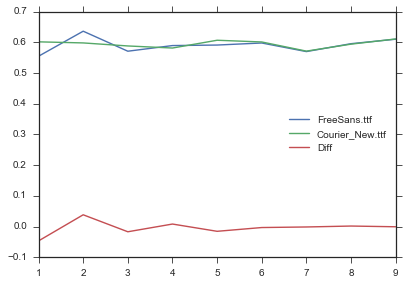

In [38]:
# Reaction time
sans_table = pd.pivot_table(data[data['Font'] == 'FreeSans'], values='RT', index='ID', columns='Value', aggfunc=np.median)
courier_table = pd.pivot_table(data[data['Font'] == 'Courier New'], values='RT', index='ID', columns='Value', aggfunc=np.median)
diff_table = pd.DataFrame(sans_table.values - courier_table.values, columns=sorted(set(data['Value'])), index=sorted(set(data['ID'])))

rt_sans = sans_table.mean()
rt_courier = courier_table.mean()
rt_diff = diff_table.mean()
rt = pd.DataFrame([rt_sans.values, rt_courier.values, rt_diff.values], columns=sorted(set(data['Value'])), index=['FreeSans.ttf', 'Courier_New.ttf', 'Diff']).T

rt.plot()

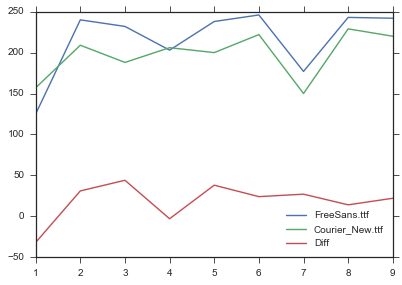

In [39]:
complexity.plot()

In [40]:
# # Reaction time
# table = pd.pivot_table(data, values='RTms', index=['Font', 'ID'], columns='Value', aggfunc=np.median)
# c_table = pd.DataFrame(stats.zscore(table)[:len(table)/2], columns=sorted(set(data['Value'])), index=sorted(set(data['ID'])))
# s_table = pd.DataFrame(stats.zscore(table)[len(table)/2:], columns=sorted(set(data['Value'])), index=sorted(set(data['ID'])))
# diff_table = pd.DataFrame(s_table.values - c_table.values, columns=sorted(set(data['Value'])), index=sorted(set(data['ID'])))

# rt_sans = s_table.mean()
# rt_courier = c_table.mean()
# rt_diff = diff_table.mean()
# rt = pd.DataFrame([rt_sans.values, rt_courier.values, rt_diff.values], columns=sorted(set(data['Value'])), index=['FreeSans.ttf', 'Courier_New.ttf', 'Diff']).T

# rt.plot()

In [41]:
stats.pearsonr(complexity['Diff'], rt['Diff'])

(0.44564076511420664, 0.2292910074379011)

In [42]:
for c in complexity.columns:
    for t in rt.columns:
        print c, t, stats.pearsonr(complexity[c], rt[t])

FreeSans.ttf FreeSans.ttf (0.72288452259901803, 0.027775680609350463)
FreeSans.ttf Courier_New.ttf (0.31172414848392682, 0.41416176607106336)
FreeSans.ttf Diff (0.59413082352533053, 0.091594777537703398)
Courier_New.ttf FreeSans.ttf (0.72402537508029574, 0.027411199750526621)
Courier_New.ttf Courier_New.ttf (0.47713905364164461, 0.19402169232370683)
Courier_New.ttf Diff (0.50324374847114262, 0.16726899364266662)
Diff FreeSans.ttf (0.40756846833953642, 0.27622423458752859)
Diff Courier_New.ttf (-0.023008027219308821, 0.95314910388657947)
Diff Diff (0.44564076511420664, 0.2292910074379011)
